# Cell2location

In [1]:
global_path = './cell-cell-communication/' ## Path to the github downloaded repository

In [2]:
import scanpy as sc
import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel
from cell2location.plt import plot_spatial
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs
import numpy as np
import diopy


import sys
sys.path.insert(1, global_path + 'Functions/')
from process_visium import visium_noh5

patient = 'CID4535' ### Change to run for the rest of the patients (CID4290, CID44971, CID4465)

/home/epareja/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [2]:
## Create folders for results

results_folder = global_path + 'Results/Breast/cell2location/'+patient+'/'
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Read spatial data

If the dataset in which you are interesting in only have raw data you will need to run the 10x spaceranger software on it. 
We need the counts matrix.h5 (in this case we don't have it so I create my own function for loading the data) and the spatial folder: 
- tissue images
- coordinates --> barcode, spot possition and image possition

In [3]:
main_path_exp = global_path + 'Data/Breast/spatial_data/filtered_count_matrices/'+patient+'_filtered_count_matrix/'
main_path_spatial = global_path + 'Data/Breast/spatial_data/spatial/'+patient+'_spatial/'
library_id = 'breast_tissue'
adata_vis = visium_noh5(main_path_exp, main_path_spatial, library_id) 

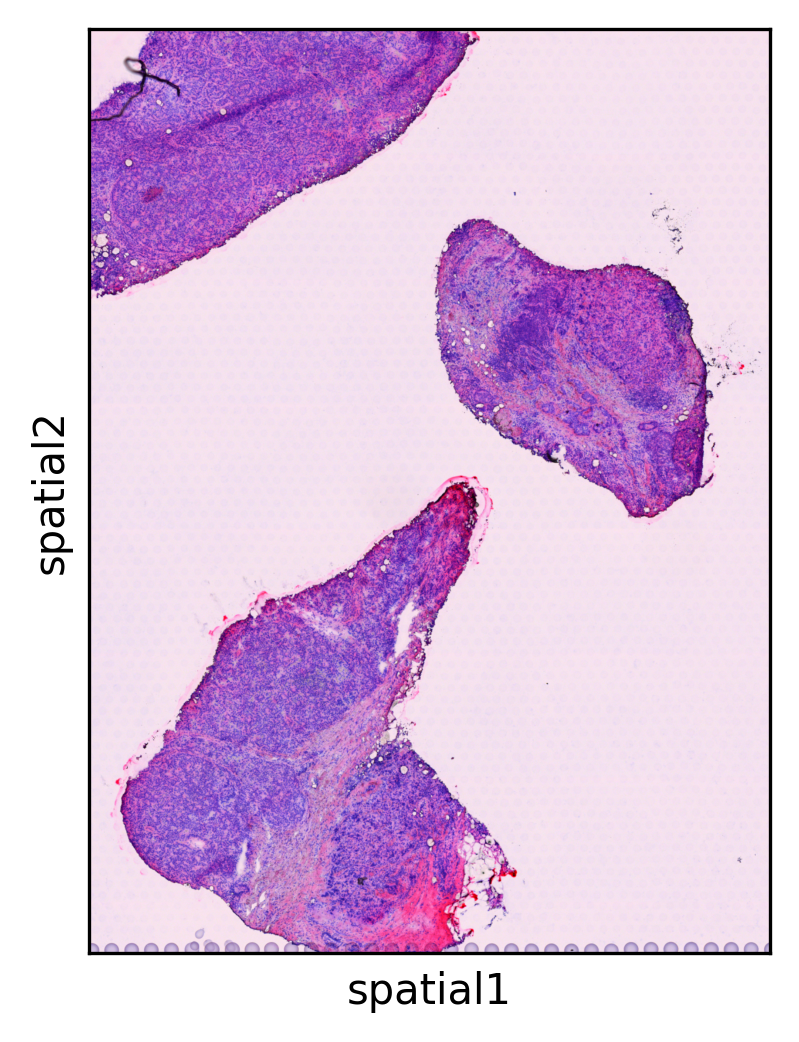

In [4]:
with plt.rc_context({'figure.figsize': (8, 4), 'figure.dpi': 300}):
    sc.pl.spatial(adata_vis, save = 'histological_image.svg')

In [5]:
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
adata_vis.var_names_make_unique()
adata_vis.var['SYMBOL'] = adata_vis.var_names

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]


## Load reference data (scRNA-seq data)

In [6]:
adata_ref = sc.read('./data/breast_normalized_log.h5ad')
adata_ref.var['SYMBOL'] = adata_ref.var.index 

# delete unnecessary raw slot 
del adata_ref.raw ## Because you don't need log normalized data, we need the count data. 

# select only counts for current patient
adata_ref = adata_ref[adata_ref.obs.Patient == patient]

# adata_ref.write('./data/adata_ref_'+patient+'.h5ad')


## Gene selection 

Before estimating the reference cell type signature, permissive genes selection (it allows to use rare genes as markers). 

/home/epareja/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/home/epareja/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


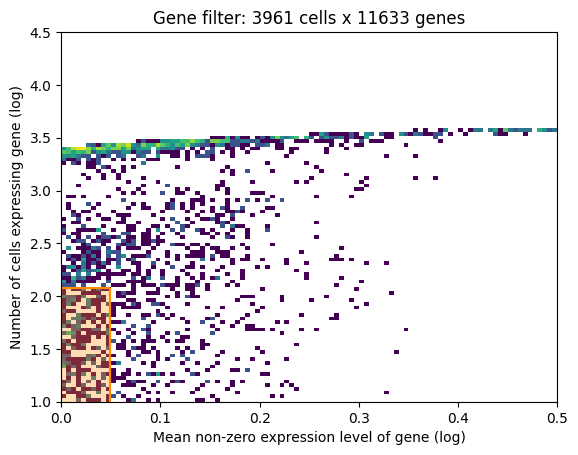

In [8]:
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# filter the object
adata_ref = adata_ref[:, selected].copy()

## Estimation of reference cell type signatures (NB regression). 

The signatures are estimated from scRNAseq data --> they yse a negative binomial regression model for accounting for batch effect. 


In [9]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # Select the layer, to not use normalize data --> if not it put a warning... 
                        layer = 'counts',
                        # 10X reaction / sample / batch
                        #batch_key='Patient', 
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype_minor'

                       )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/home/epareja/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/_utils.py:172: UserWarning: Category 3 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [15]:
mod = RegressionModel(adata_ref) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': 'celltype_minor',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 5789  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  27   │
│          n_vars          │ 12512 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                               labels State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location       ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype_minor'] │       B cells Memory        │          0          │
│                             │     CAFs MSC iCAF-like      │          1          │
│                             │       CAFs myCAF-like       │          2          │
│                             │       Cancer Basal SC       │          3          │
│                             │       Cancer Cycling        │          4          │
│                             │       Cancer Her2 SC        │          5          │
│                             │       Cancer LumA SC        │          6          │
│                             │       Cancer LumB SC        │          7          │
│                             │         Cycling PVL         │          8          │
│                             │       Cycling T-cells       │          9          │
│                             │       Cycling_Myeloid       │         10          │
│                             │             DCs             │         11          │
│                             │      Endothelial ACKR1      │         12          │
│                             │     Endothelial CXCL12      │         13          │
│                             │ Endothelial Lymphatic LYVE1 │         14          │
│                             │      Endothelial RGS5       │         15          │
│                             │     Luminal Progenitors     │         16          │
│                             │         Macrophage          │         17          │
│                             │       Mature Luminal        │         18          │
│                             │          Monocyte           │         19          │
│                             │        Myoepithelial        │         20          │
│                             │          NK cells           │         21          │
│                             │          NKT cells          │         22          │
│                             │     PVL Differentiated      │         23          │
│                             │        PVL Immature         │         24          │
│                             │        T cells CD4+         │         25          │
│                             │        T cells CD8+         │         26          │
└─────────────────────────────┴─────────────────────────────┴─────────────────────┘

### Train the model

In [16]:
mod.train(max_epochs=250)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/py37/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/miniconda3/envs/py37/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 250/250: 100%|██████████| 250/250 [08:53<00:00,  2.16s/it, v_num=1, elbo_train=3.21e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [08:53<00:00,  2.13s/it, v_num=1, elbo_train=3.21e+7]


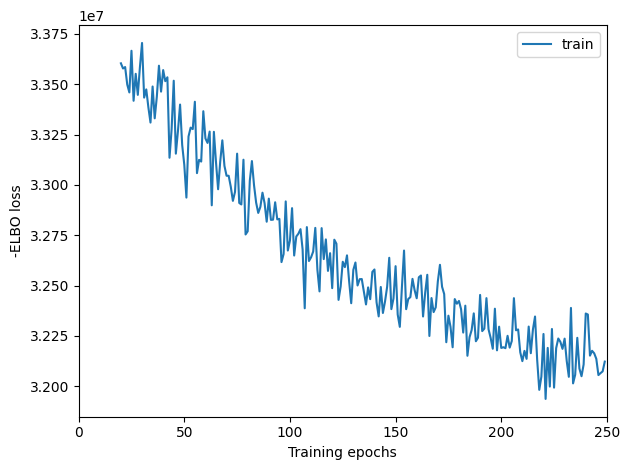

In [17]:
mod.plot_history(20) ## This is for determining if the model needs more training. I dont think so because it seem to decrease but also to increase.

In [18]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution). This is needed for doing the deconvolution
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)


Sampling global variables, sample: 100%|██████████| 999/999 [01:00<00:00, 16.53it/s]


'/home/sbnb/epareja/2022/single_cell/breast_cancer/results/cell2location/Results/cell2location_patient_CID4290//reference_signatures/sc.h5ad'

### Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

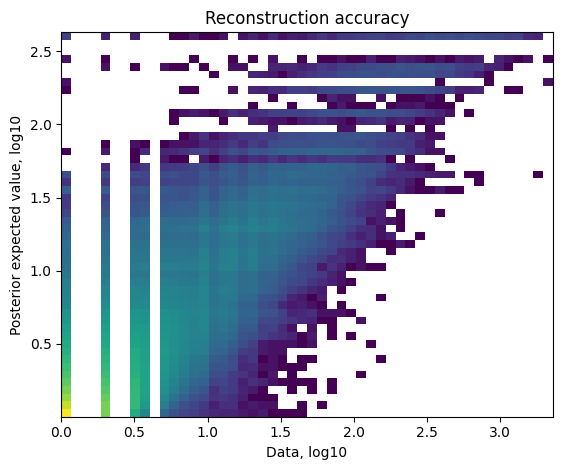

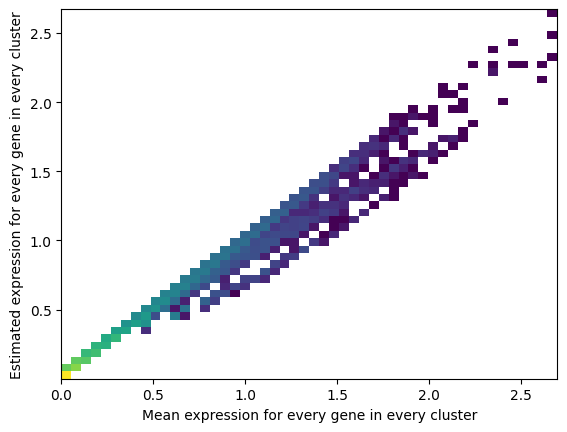

In [19]:
mod.plot_QC()

In [20]:
### This is for loading the model and output
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)


INFO     File                                                                                                      
         /home/sbnb/epareja/2022/single_cell/breast_cancer/results/cell2location/Results/cell2location_patient_CID4
         290//reference_signatures/model.pt already downloaded                                                     


/opt/miniconda3/envs/py37/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 8 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/py37/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/miniconda3/envs/py37/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|          | 1/1000 [00:00<12:07,  1.37it/s, v_num=1, elbo_train=3.43e+7]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/1000:   0%|          | 1/1000 [00:00<12:14,  1.36it/s, v_num=1, elbo_train=3.43e+7]


### Extracting reference cell types signatures 

For spatial mapping we just need the estimated expression of every gene in every cell type. 

In [21]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B cells Memory  CAFs MSC iCAF-like  CAFs myCAF-like  \
FO538757.2        0.023421            0.104413         0.094738   
NOC2L             0.049616            0.069976         0.098617   
PLEKHN1           0.000474            0.000470         0.023011   
HES4              0.000474            0.120927         0.157016   
ISG15             0.059499            0.397098         0.950951   

            Cancer Basal SC  Cancer Cycling  
FO538757.2         0.136409        0.155166  
NOC2L              0.108790        0.284992  
PLEKHN1            0.000494        0.073704  
HES4               0.129988        0.415503  
ISG15              0.134814        0.116651

## Spatial mapping

#### 1. Find shared genes and prepare anndata

In [22]:
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [24]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

#### 2. Choosing hyperparameters

- `Number of cell per location`: Expected cell abundance per spot. The estimation for Visium 55 is N=5
- `Detection alpha`: Regularization for taking into account the differences in RNA detection across the tissue. This is for improving accuracy and sensitivity on datasets with large techinical variability. In Visium is recomendated to use 20.

In [25]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=5,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
) 
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2432  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11542 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ breast_tissue │          0          │
└─────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

### Train the model

In [ ]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/py37/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/miniconda3/envs/py37/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 18977/30000:  63%|██████▎   | 18976/30000 [3:36:58<2:04:21,  1.48it/s, v_num=1, elbo_train=1.79e+7]

In [ ]:
mod.plot_history(1000)
mod.plot_QC()
mod.plot_spatial_QC_across_batches()


### Extract estimated cell abundances

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)


We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present').

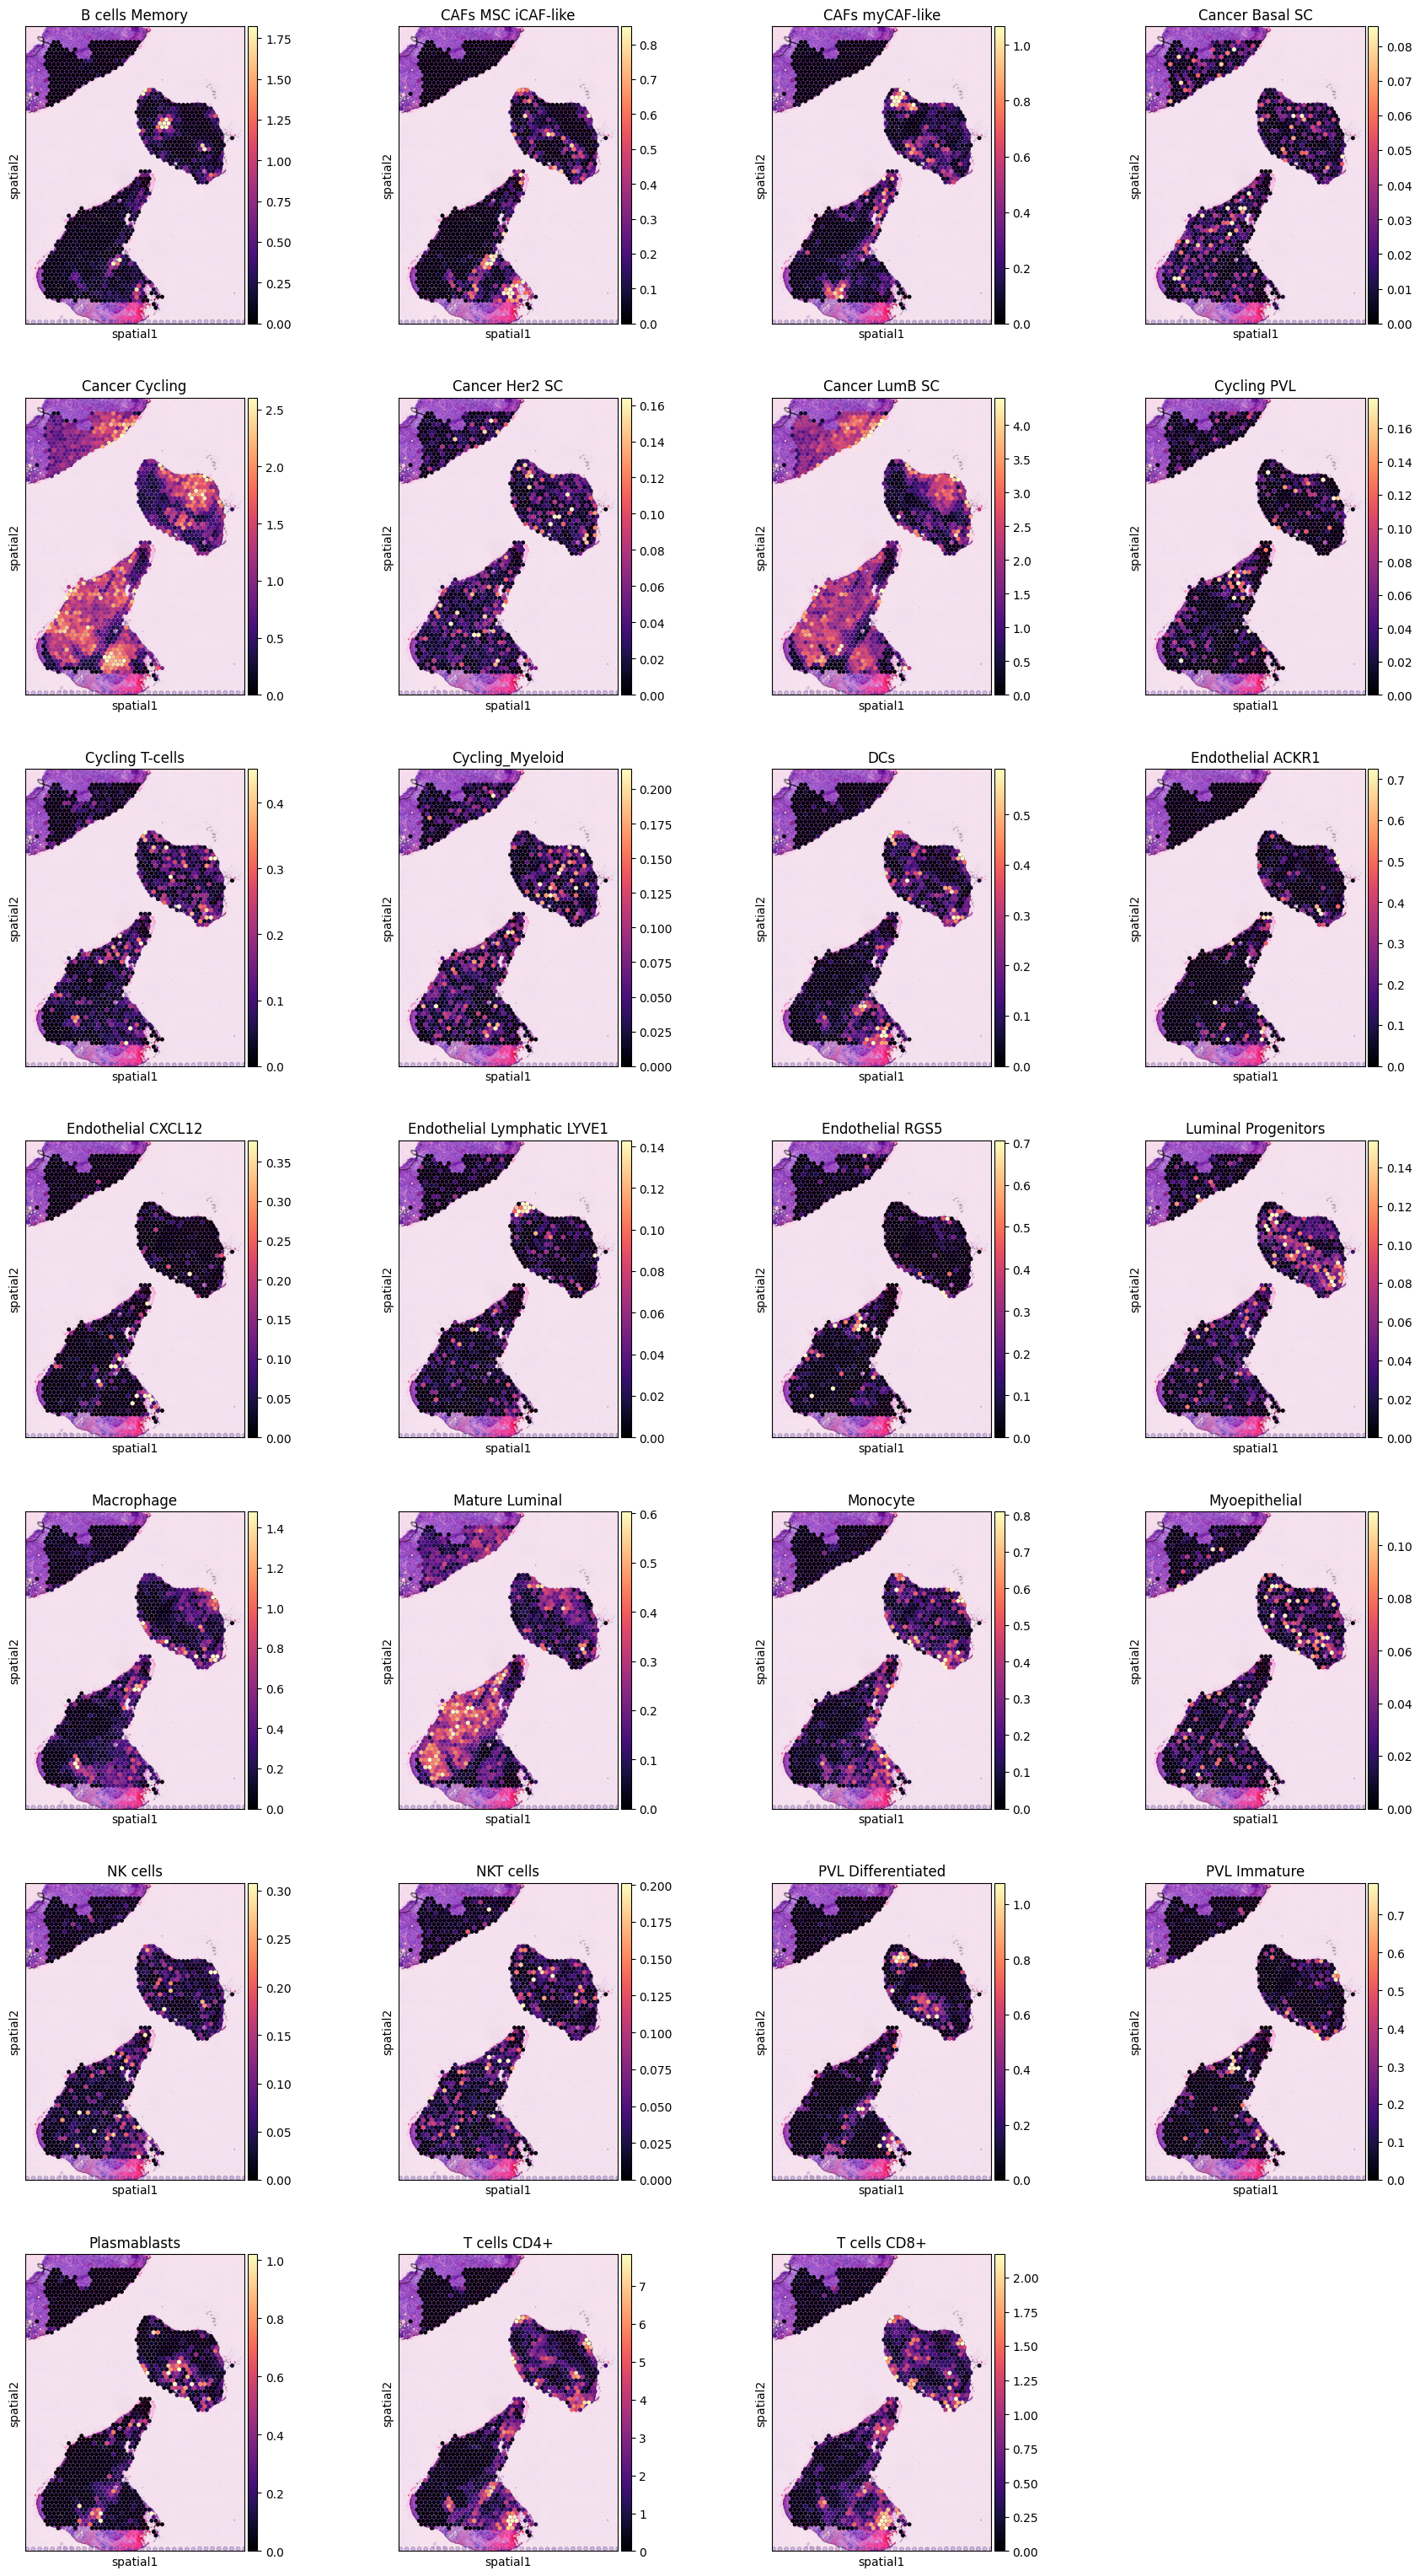

In [12]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']


# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(adata_vis, cmap='magma',
                  # show first 8 cell types
                  color=adata_vis.uns['mod']['factor_names'], 
                  ncols=4, size=1.5, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

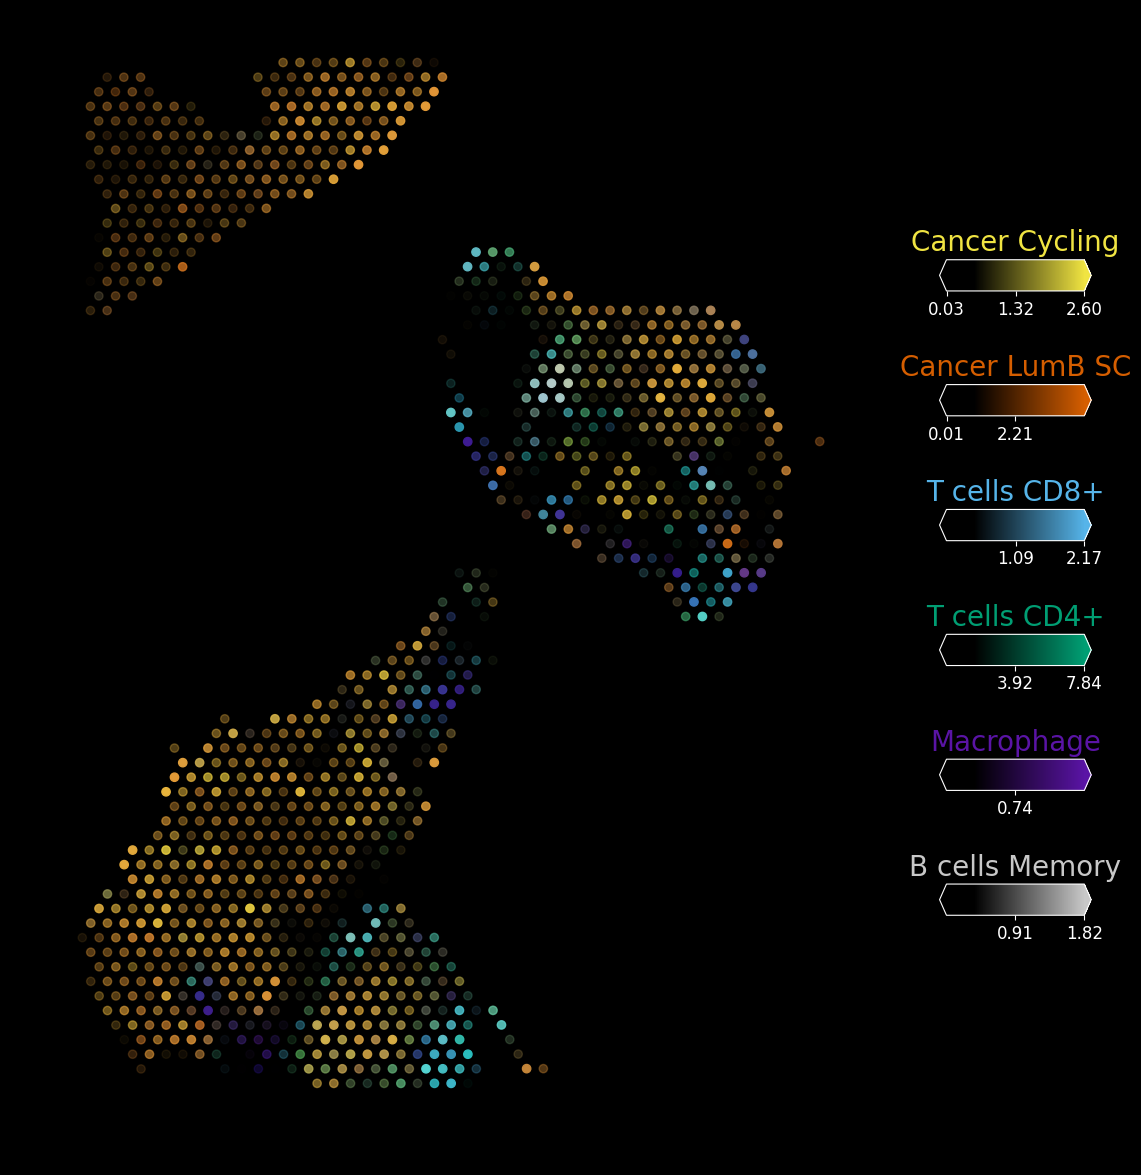

In [14]:
#Now we use cell2location plotter that allows showing multiple cell types in one panel
# select up to 6 clusters 
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

clust_labels = [ 'Cancer Cycling', 'Cancer LumB SC', 'T cells CD8+', 'T cells CD4+', 'Macrophage', 'B cells Memory']

clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels


with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=adata_vis, 
        # labels to show on a plot
        color=clust_col, labels=clust_labels, 
        show_img=False,
        # 'fast' (white background) or 'dark_background'
        style='dark_background', 
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6, 
        colorbar_position='right'
    )
plt.show()